In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from palbociclib_signature_analysis import palbo_signatures
from palbo_RNAseq_analysis import palbo_RNAseq
from Integrative_analysis import geneset_heatmap, build_library

In [3]:
geneset_library = build_library()

In [7]:
geneset1 = geneset_library['TGF-beta Signaling']
geneset2 = geneset_library['G2-M Checkpoint']
geneset3 = geneset_library['Myc Targets V1']

In [10]:
palbo_seq = palbo_RNAseq("./input_data/palbo_RNAseq/palbociclib_gene_list.txt")
fpath1="./input_data//palbo_signature/CCLE_palbo_CDK6.csv"
fpath2="./input_data/palbo_signature/CCLE_palbo_RB1.csv" 
palbo_sig = palbo_signatures(fpath1, fpath2)

In [13]:
palbo_sig.combo['Partner'].isin(geneset1).sum()

13

Genes in CARE data: 37
Genes in sequencing data: 71
Overlapping genes: 9


<Figure size 800x1000 with 0 Axes>

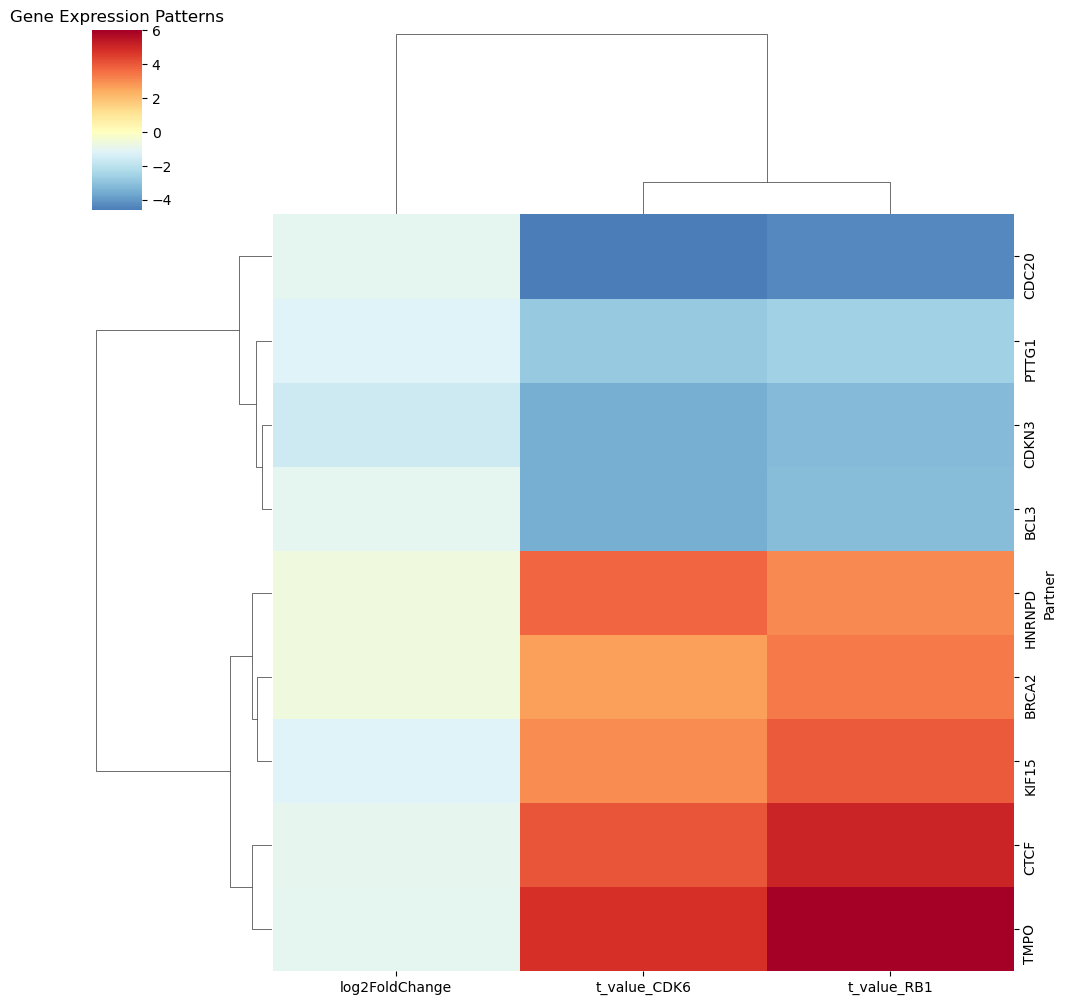

In [9]:
geneset_heatmap(geneset2, palbo_sig.combo, palbo_seq.gene_summary)

In [124]:
fpath="./input_data/Enrichment/MSigDB_Hallmark_2020.txt"

with open(fpath, 'r') as f:
        lines = f.readlines()
    
library = {}
for line in lines:
    parts = line.strip().split('\t')
    new_parts = []
    for part in parts:
         if part != '':
               new_parts.append(part)
    library[new_parts[0]] = new_parts[1:] 

In [148]:
geneset_heatmap(gen)

In [ ]:
def set_presence(gene_set, care_data, seq_data, save_csv=False):
    """Analyze gene set presence in different datasets"""
    set_at_care = care_data[care_data['Partner'].isin(gene_set)]
    set_at_seq = seq_data[seq_data['GeneName'].isin(gene_set)]
    
    overlap = pd.merge(set_at_care, set_at_seq, 
                      left_on='Partner', right_on='GeneName')
    
    print(f"Genes in CARE data: {len(set_at_care)}")
    print(f"Genes in sequencing data: {len(set_at_seq)}")
    print(f"Overlapping genes: {len(overlap)}")
    
    # Create heatmap
    plot_data = overlap[['log2FoldChange', 't_value']].copy()
    plot_data.index = overlap['Partner']
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(plot_data, cmap='RdYlBu_r', center=0)
    plt.title('Gene Expression Patterns')
    
    if save_csv:
        output_name = f"{gene_set.name}_presence.csv"
        overlap.to_csv(f"./Processed_data_output/{output_name}")
    
    return overlap

def build_library(fpath="./Enrichment/library/MSigDB_Hallmark_2020.txt"):
    """Build enrichment library"""
    with open(fpath, 'r') as f:
        lines = f.readlines()
    
    library = {}
    for line in lines:
        parts = line.strip().split('\t')
        library[parts[0]] = parts[1:]
    
    return library

class ComplexHeatmap:
    """Python implementation of R's ComplexHeatmap"""
    def __init__(self, data, split_cols=None, annotations=None):
        self.data = data
        self.split_cols = split_cols
        self.annotations = annotations
    
    def plot(self):
        fig = plt.figure(figsize=(12, 8))
        
        if self.annotations:
            gs = plt.GridSpec(len(self.annotations) + 1, 1, height_ratios=[1]*len(self.annotations) + [4])
            
            for i, (name, values) in enumerate(self.annotations.items()):
                ax = fig.add_subplot(gs[i])
                if isinstance(values, pd.Series):
                    values.plot(kind='bar', ax=ax)
                else:
                    ax.imshow([values], aspect='auto')
                ax.set_title(name)
        
        ax_main = fig.add_subplot(gs[-1])
        sns.heatmap(self.data, ax=ax_main, cmap='RdBu_r')
        
        if self.split_cols:
            for split in np.unique(self.split_cols):
                plt.axvline(x=(self.split_cols == split).sum(), color='black', linewidth=2)
        
        plt.tight_layout()
        return fig




In [128]:
class ComplexHeatmap:
    """Python implementation of R's ComplexHeatmap"""
    def __init__(self, data, split_cols=None, annotations=None):
        self.data = data
        self.split_cols = split_cols
        self.annotations = annotations
    
    def plot(self):
        fig = plt.figure(figsize=(12, 8))
        
        if self.annotations:
            gs = plt.GridSpec(len(self.annotations) + 1, 1, height_ratios=[1]*len(self.annotations) + [4])
            
            for i, (name, values) in enumerate(self.annotations.items()):
                ax = fig.add_subplot(gs[i])
                if isinstance(values, pd.Series):
                    values.plot(kind='bar', ax=ax)
                else:
                    ax.imshow([values], aspect='auto')
                ax.set_title(name)
        
        ax_main = fig.add_subplot(gs[-1])
        sns.heatmap(self.data, ax=ax_main, cmap='RdBu_r')
        
        if self.split_cols:
            for split in np.unique(self.split_cols):
                plt.axvline(x=(self.split_cols == split).sum(), color='black', linewidth=2)
        
        plt.tight_layout()
        return fig

{'TNF-alpha Signaling via NF-kB': ['',
  'MARCKS',
  'IL23A',
  'NINJ1',
  'TNFSF9',
  'SIK1',
  'ATF3',
  'SERPINE1',
  'MYC',
  'HES1',
  'CCNL1',
  'CCN1',
  'EGR1',
  'EGR2',
  'JAG1',
  'EGR3',
  'ABCA1',
  'GADD45B',
  'GADD45A',
  'PLK2',
  'KLF10',
  'EIF1',
  'EHD1',
  'FOSL2',
  'FOSL1',
  'GPR183',
  'PLPP3',
  'IFIT2',
  'ICAM1',
  'ZC3H12A',
  'IER2',
  'IL12B',
  'JUNB',
  'IER5',
  'IER3',
  'STAT5A',
  'DUSP5',
  'EDN1',
  'JUN',
  'DUSP4',
  'DUSP1',
  'DUSP2',
  'TSC22D1',
  'CCL20',
  'SPHK1',
  'LIF',
  'IL18',
  'TUBB2A',
  'RHOB',
  'VEGFA',
  'PTPRE',
  'IL1A',
  'TLR2',
  'IL1B',
  'BHLHE40',
  'ID2',
  'CLCF1',
  'REL',
  'FJX1',
  'SGK1',
  'BTG3',
  'BTG2',
  'BTG1',
  'SDC4',
  'LITAF',
  'AREG',
  'SOCS3',
  'PANX1',
  'RIPK2',
  'NFIL3',
  'SERPINB2',
  'GCH1',
  'IFNGR2',
  'G0S2',
  'FOS',
  'SERPINB8',
  'F3',
  'SPSB1',
  'FOSB',
  'PER1',
  'F2RL1',
  'HBEGF',
  'CD44',
  'TRIP10',
  'CDKN1A',
  'PTGER4',
  'PTGS2',
  'IFIH1',
  'NAMPT',
  'OLR1',
  '